# Gene sorting by KEGG functional annotations (TreeMap)
This notebook is based on the paper *OmicsMapNet: Transforming omics data to take advantage of Deep Convolutional Neural Network for discovery*, whose authors are *Shiyong Ma, Zhen Zhang* (https://arxiv.org/ftp/arxiv/papers/1804/1804.05283.pdf)
- Paper summary: 
Their aim was to rearrange high-dimensional omics data as 2-dimensional images, and train a Keras-CNN with them. For that, they used KEGG database which provides functional anotation of genes. Specifically, KEGG BRITE captures 'the functional hierarchies of biological objects'. And based on this hierarchy, each omic vector was shaped as an image using a treemap.

In [1]:
#libraries
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import squarify 

###  KEGG and TCGA data loading

- Data coming from KEGG database is fetched on 'KEGG_Data_obtaining.ipynb' notebook
- Data coming from TCGA database is fetched on 'TCGA_Data_obtaining.ipynb' notebook

In [2]:
# KEGG
hsa = pd.read_csv('data/KEGG/KEGG_gene_hsa.csv', sep='\t'  , engine='python', header=None, index_col=0)
hsa_brite = pd.read_csv('data/KEGG/KEGG_hsa_brite.csv', sep='\t'  , engine='python', header=None)
hsa_brite.columns = ['keggBriteId', 'keggId']
brite = pd.read_csv('data/KEGG/KEGG_brite.csv', engine='python', header=0, index_col=0)

# TCGA

# pp_df_gene_exp = pd.read_hdf("data/preprocessed1_expr.h5", key='expression') # only selected features
# df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_10.h5", key = "brca")
non_brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_10.h5", key = "non_brca")

In [11]:
hsa_brite['keggBriteId'] = [br_id[7:] for br_id in hsa_brite['keggBriteId']]

In [12]:
brite_homosap_index = list(set(brite['keggBriteId']).intersection(set(hsa_brite['keggBriteId'])))

In [13]:
brite = brite.loc[brite['keggBriteId'].isin(brite_homosap_index)]

In [10]:
ens_genes = brca_ex.columns

In [13]:
print("Initial number of genes: {}".format(len(ens_genes)))

Initial number of genes: 10000


In [5]:
print("Total number of samples (patients): {}".format(brca_ex.shape[0]+non_brca_ex.shape[0]))

Total number of samples (patients): 10535


## MAPPING: From Ensembl Gene ID to KEGG BRITE functional annotation
KEGG relates Hugo-gene-names to an internal id (KEGG id) that is useful to find out the corresponding KEGG BRITE value/s (hierarchical functional annotations) of each gene.
Due to genes in TCGA are indexed by Ensembl-ids, it is needed mapping Ensembl-id to Hugo-gene-name

All the code below (mappings) can be ignored until next section just loading 'gene_mapping' DataFrame, which contains mapping from Ensembl id to KEGG Brite

In [35]:
# Loading 'gene_mapping' DataFrame
gene_mapping = pd.read_hdf('data/KEGG/map_ens_kegg_brite.h5', key='map')

### Mapping: Ensembl Gene ID to  Hugo Gene Name
Down below, it is downloaded a table relating ensembl-ids and hugo-gene-names from this URL: https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv

In [17]:
%%time

url = 'https://raw.githubusercontent.com/jvivian/docker_tools/master/gencode_hugo_mapping/attrs.tsv'
hugo_request = requests.get(url, allow_redirects=True)
open('data/hugo_ensembl.tsv', 'wb').write(hugo_request.content)
del hugo_request

CPU times: user 292 ms, sys: 230 ms, total: 521 ms
Wall time: 3.95 s


In [10]:
hugo_ens = pd.read_csv('data/hugo_ensembl.tsv', sep='\t', engine='python', index_col=0)

In [11]:
hugo_ens = hugo_ens[~hugo_ens.index.duplicated()]

common_genes = hugo_ens.index.intersection(ens_genes)
hugo_ens = hugo_ens.loc[common_genes, :]

len(common_genes)

10000

In [12]:
hugo_ens

,geneName,geneType,geneStatus,transcriptId,transcriptName,transcriptType,transcriptStatus,havanaGeneId,havanaTranscriptId,ccdsId,level,transcriptClass
ENSG00000269981.1,RP11-34P13.16,processed_pseudogene,KNOWN,ENST00000595919.1,RP11-34P13.16-001,processed_pseudogene,KNOWN,OTTHUMG00000182738.2,OTTHUMT00000463398.2,NaN,2,pseudo
ENSG00000241670.3,RPL23AP21,processed_pseudogene,KNOWN,ENST00000450734.1,RPL23AP21-001,processed_pseudogene,KNOWN,OTTHUMG00000002552.1,OTTHUMT00000007241.1,NaN,1,pseudo
ENSG00000236679.2,RPL23AP24,processed_pseudogene,KNOWN,ENST00000458203.2,RPL23AP24-004,processed_pseudogene,KNOWN,OTTHUMG00000002854.4,OTTHUMT00000346877.2,NaN,1,pseudo
ENSG00000231709.1,RP5-857K21.1,lincRNA,KNOWN,ENST00000417636.1,RP5-857K21.1-001,lincRNA,KNOWN,OTTHUMG00000002261.1,OTTHUMT00000006453.1,NaN,2,nonCoding
ENSG00000240409.1,MTATP8P1,unprocessed_pseudogene,KNOWN,ENST00000467115.1,MTATP8P1-001,unprocessed_pseudogene,KNOWN,OTTHUMG00000002473.1,OTTHUMT00000007027.1,NaN,2,pseudo
ENSG00000229376.3,CICP3,processed_pseudogene,KNOWN,ENST00000440782.3,CICP3-001,processed_pseudogene,KNOWN,OTTHUMG00000057431.3,OTTHUMT00000127611.3,NaN,1,pseudo
ENSG00000240618.1,RP11-206L10.5,lincRNA,KNOWN,ENST00000417659.1,RP11-206L10.5-001,lincRNA,KNOWN,OTTHUMG00000002409.1,OTTHUMT00000006892.1,NaN,2,nonCoding
ENSG00000230368.2,FAM41C,lincRNA,KNOWN,ENST00000446136.1,FAM41C-001,lincRNA,KNOWN,OTTHUMG00000002469.1,OTTHUMT00000007021.1,NaN,2,nonCoding
ENSG00000230699.2,RP11-54O7.1,lincRNA,KNOWN,ENST00000448179.1,RP11-54O7.1-001,lincRNA,KNOWN,OTTHUMG00000040716.1,OTTHUMT00000097856.1,NaN,2,nonCoding
ENSG00000223764.2,RP11-54O7.3,lincRNA,KNOWN,ENST00000609207.1,RP11-54O7.3-003,retained_intron,KNOWN,OTTHUMG00000040718.2,OTTHUMT00000473217.1,NaN,2,problem


In [13]:
gene_mapping = pd.DataFrame(hugo_ens.loc[:,'geneName'])

In [14]:
gene_mapping['ensId'] = gene_mapping.index

In [15]:
gene_mapping['geneName']

ENSG00000269981.1      RP11-34P13.16
ENSG00000241670.3          RPL23AP21
ENSG00000236679.2          RPL23AP24
ENSG00000231709.1       RP5-857K21.1
ENSG00000240409.1           MTATP8P1
ENSG00000229376.3              CICP3
ENSG00000240618.1      RP11-206L10.5
ENSG00000230368.2             FAM41C
ENSG00000230699.2        RP11-54O7.1
ENSG00000223764.2        RP11-54O7.3
ENSG00000187634.10            SAMD11
ENSG00000187583.10           PLEKHN1
ENSG00000187642.9              PERM1
ENSG00000272512.1       RP11-54O7.17
ENSG00000273443.1       RP11-54O7.18
ENSG00000237330.2             RNF223
ENSG00000223823.1          LINC01342
ENSG00000272141.1      RP11-465B22.8
ENSG00000205231.1         TTLL10-AS1
ENSG00000162571.13            TTLL10
ENSG00000186891.13          TNFRSF18
ENSG00000264293.2          RN7SL657P
ENSG00000235098.8            ANKRD65
ENSG00000225905.1       RP4-758J18.7
ENSG00000215915.9             ATAD3C
ENSG00000272004.1      RP11-345P4.10
ENSG00000269227.1       RP11-345P4.6
E

### Mapping: Hugo Gene Name to KEGG gene id

In [16]:
hsa_hugo_dict = dict()
for i in range(0, len(hsa)):
    value = hsa.loc[hsa.index[i],1].split(";")[0].split(',')
    if 'uncharacterized' not in value[0] and len(value[0])<20:
        hsa_hugo_dict[hsa.index[i]] = value

In [17]:
len(hsa_hugo_dict)

26988

In [18]:
%%time
hsa_hugo = pd.DataFrame(columns=['keggId','geneName'])
i = 0
for key, values in hsa_hugo_dict.items():
    for ens in values:
        hsa_hugo.loc[i] = [key, ens]
        i+=1

CPU times: user 3min 9s, sys: 115 ms, total: 3min 9s
Wall time: 3min 9s


In [19]:
hsa_hugo.shape

(86160, 2)

In [20]:
gene_mapping = pd.merge(gene_mapping, hsa_hugo, on='geneName')

### Mapping: KEGG gene id to KEGG BRITE id

In [21]:
gene_mapping

,geneName,ensId,keggId
0,FAM41C,ENSG00000230368.2,hsa:284593
1,SAMD11,ENSG00000187634.10,hsa:148398
2,PLEKHN1,ENSG00000187583.10,hsa:84069
3,PERM1,ENSG00000187642.9,hsa:84808
4,RNF223,ENSG00000237330.2,hsa:401934
5,LINC01342,ENSG00000223823.1,hsa:254099
6,TTLL10-AS1,ENSG00000205231.1,hsa:100506376
7,TTLL10,ENSG00000162571.13,hsa:254173
8,TNFRSF18,ENSG00000186891.13,hsa:8784
9,ANKRD65,ENSG00000235098.8,hsa:441869


In [22]:
len(set(hsa_brite['keggId'].value_counts().index).intersection(gene_mapping['keggId']))

3443

In [23]:
gene_mapping = pd.merge(gene_mapping, hsa_brite, on='keggId')

In [24]:
gene_mapping

,geneName,ensId,keggId,keggBriteId
0,TNFRSF18,ENSG00000186891.13,hsa:8784,0001
1,TNFRSF18,ENSG00000186891.13,hsa:8784,4090
2,TNFRSF18,ENSG00000186891.13,hsa:8784,4050
3,GABRD,ENSG00000187730.7,hsa:2563,0001
4,GABRD,ENSG00000187730.7,hsa:2563,4040
5,PLCH2,ENSG00000149527.17,hsa:9651,0001
6,PLCH2,ENSG00000149527.17,hsa:9651,1000
7,PLCH2,ENSG00000149527.17,hsa:9651,4131
8,HES5,ENSG00000197921.5,hsa:388585,0001
9,HES5,ENSG00000197921.5,hsa:388585,3000


### Mapping: KEGG BRITE id to KEGG BRITE functional annotation

In [25]:
gene_mapping = pd.merge(gene_mapping, brite, on='keggBriteId')

In [26]:
brite

,Functional Annotation Group,Functional Annotation Subgroup,keggBriteId,Functional Annotation
4,Genes and Proteins,Orthologs and modules,0001,KEGG Orthology (KO)
7,Genes and Proteins,Protein families: metabolism,1000,Enzymes
8,Genes and Proteins,Protein families: metabolism,1001,Protein kinases
9,Genes and Proteins,Protein families: metabolism,1009,Protein phosphatases and associated proteins
10,Genes and Proteins,Protein families: metabolism,1002,Peptidases
11,Genes and Proteins,Protein families: metabolism,1003,Glycosyltransferases
14,Genes and Proteins,Protein families: metabolism,1004,Lipid biosynthesis proteins
16,Genes and Proteins,Protein families: metabolism,1006,Prenyltransferases
17,Genes and Proteins,Protein families: metabolism,1007,Amino acid related enzymes
18,Genes and Proteins,Protein families: metabolism,0199,Cytochrome P450


In [18]:
gene_mapping

,geneName,ensId,keggId,keggBriteId,Functional Annotation Group,Functional Annotation Subgroup,Functional Annotation
0,TNFRSF18,ENSG00000186891.13,hsa:8784,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
1,GABRD,ENSG00000187730.7,hsa:2563,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
2,PLCH2,ENSG00000149527.17,hsa:9651,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
3,HES5,ENSG00000197921.5,hsa:388585,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
4,MMEL1,ENSG00000142606.15,hsa:79258,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
5,PRDM16,ENSG00000142611.16,hsa:63976,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
6,TP73,ENSG00000078900.14,hsa:7161,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
7,AJAP1,ENSG00000196581.10,hsa:55966,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
8,CHD5,ENSG00000116254.17,hsa:26038,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)
9,HES2,ENSG00000069812.11,hsa:54626,0001,Genes and Proteins,Orthologs and modules,KEGG Orthology (KO)


## Mapping: KEGG BRITE functional annotation to KEGG BRITE group of functional annotations

### Mapping: exporting gene_mapping DataFrame

In [28]:
with pd.HDFStore('data/KEGG/map_ens_kegg_brite.h5') as store:
    store['map'] = gene_mapping

# TREEMAP generation

In [31]:
exp_to_tree_map = pd.concat([non_brca_ex, brca_ex]).T
exp_to_tree_map['ensId'] = exp_to_tree_map.index
exp_to_tree_map['tamPixel'] = np.ones(exp_to_tree_map.shape[0])
exp_to_tree_map['order'] = pd.concat([non_brca_ex, brca_ex]).mean() # order genes in the map by mean expression level
exp_to_tree_map = pd.merge(gene_mapping, exp_to_tree_map, on='ensId')

In [32]:
%%time
exp_to_tree_map.to_csv('exp_to_tree_map.csv')

CPU times: user 59.3 s, sys: 2.16 s, total: 1min 1s
Wall time: 1min 1s


In [44]:
exp_to_tree_map.shape

(7909, 10544)

http://rpy.sourceforge.net/rpy2/doc-2.4/html/interactive.html

In [41]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
%%R

source('Gene_KEGG_treemap_generator.R')

[1] "loading file"
[1] "file loaded"
Time difference of 24.93878 secs
Time difference of 18,88675 secs


In [49]:
# DL with Python - François Chollet (pp. 162-163)
from keras.preprocessing import image

img2 = image.load_img("data/KEGG/KEGG_TREEMAPS_2/ TCGA.02.0047.01_NON_BRCA _TREEMAP.png")
            
#x = image.img_to_array(img)
#x= x.reshape((1,) + x.shape)

In [175]:
%%time

brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "brca")
non_brca_ex = pd.read_hdf("/mnt/ext/almacen/comun/Francis/almacen/DeepLearning-Bioinformatics/data/PanCancer/mad_filter_pancan_all_TCGA_20.h5", key = "non_brca")

CPU times: user 143 ms, sys: 2.52 s, total: 2.67 s
Wall time: 9.08 s


In [51]:
img

NameError: name 'img' is not defined

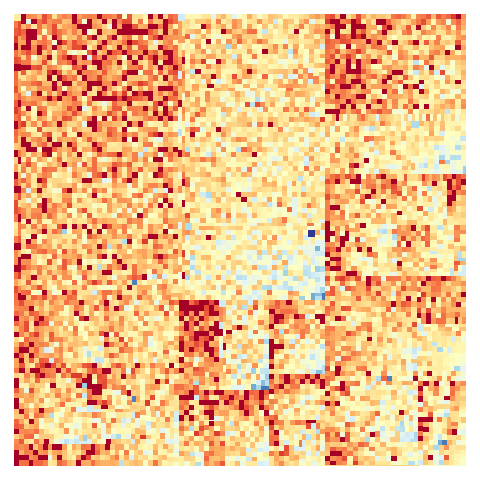

In [52]:
img2

In [6]:
w, h = img2.size
img2 = img2.crop((11, 11, w-13, h-13))

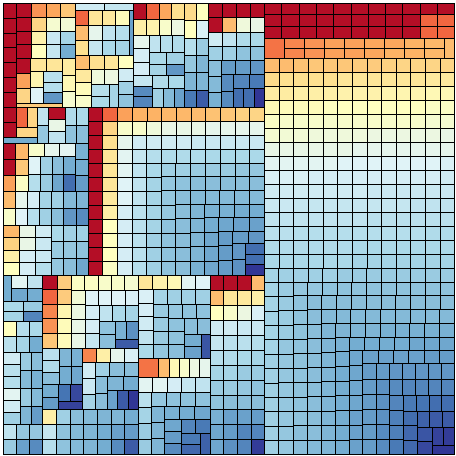

In [172]:
img2

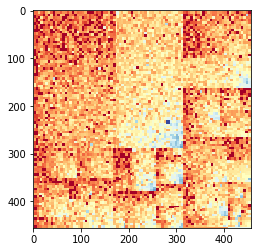

In [7]:
from matplotlib.pyplot import imshow
%matplotlib inline
imshow(img2)

In [99]:
import numpy as np
from PIL import Image # conda install pillow

image = Image.open('prueba.png', mode="rgb")
nparray=np.array(image)

ValueError: bad mode 'rgb'

In [ ]:
img = img.convert("RGBA")

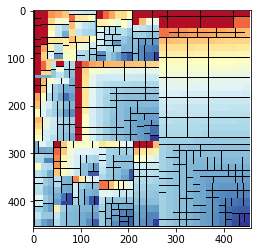

In [12]:
df_gene_exp = pd.read_hdf("data/TCGA_data.h5", key='both_gene_expression') # all

In [13]:
pat1 = pd.DataFrame(df_gene_exp.iloc[0])
pat1['ensId'] = pat1.index
del df_gene_exp

In [13]:
pat1 = pd.merge(gene_mapping, pat1, on='ensId')

In [36]:
pat1['ensId'].shape

(32004,)

In [62]:
pat1.to_csv('pat1.csv')

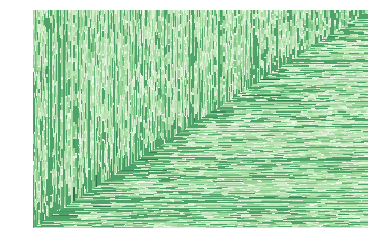

In [98]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=abs(pat1['TCGA-19-1787-01'])*100
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Greens
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors)
plt.axis('off')
plt.show()

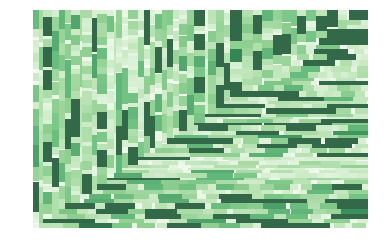

In [106]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
pat1_ = pat1.loc[pat1['Functional Annotation']=="Transcription factors"]
my_values=abs(pat1_['TCGA-19-1787-01'])*100
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Greens
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors)
plt.axis('off')
plt.show()

In [69]:
first_tree = pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())

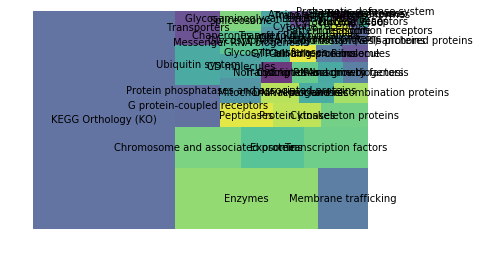

In [100]:
squarify.plot(sizes=first_tree['Functional Annotation'], label=first_tree.index, alpha=.8)
plt.axis('off')
plt.show()

In [92]:
import squarify

# these values define the coordinate system for the returned rectangles
# the values will range from x to x + width and y to y + height
x = 0.
y = 0.
width = 700.
height = 433.

values = [500, 433, 78, 25, 25, 7]

# values must be sorted descending (and positive, obviously)
values.sort(reverse=True)

# the sum of the values must equal the total area to be laid out
# i.e., sum(values) == width * height
values = squarify.normalize_sizes(values, width, height)

# returns a list of rectangles
rects = squarify.squarify(values, x, y, width, height)

# padded rectangles will probably visualize better for certain cases
padded_rects = squarify.padded_squarify(values, x, y, width, height)

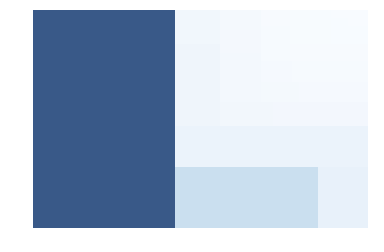

In [18]:
#libraries
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import squarify # pip install squarify (algorithm for treemap)&lt;/pre&gt;
 
# Create a dataset:
my_values=pd.DataFrame(gene_mapping['Functional Annotation'].value_counts())['Functional Annotation']
 
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, color=colors )
plt.axis('off')
plt.show()
